__Author:__ Soheil Esmaeilzadeh

__Email:__ soheil.esmaeilzadeh@gmail.com / soes@stanford.edu

__Date:__ 12/10/2018

## Time Series Forecast by Deep Gated Recurrent Neural Network (DGRU)
In this notebook we use __Deep Gated Recurrent Neural Network (DGRU)__ to __forecast__ a time series given its history information in the past. The model uses RNN and a hyperparameter study can easily be done by the user (e.g. changing the number of layers, number of epochs, size of each layer, drop-out coefficient, and etc.). At the end the forecasted results are compared against a __Decline Curve Analysis (DCA) approach__ for oil and gas applications.

In [5]:
import numpy as np
import tensorflow as tf
import random as rn
import numpy as np
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ['PYTHONHASHSEED'] = '0'
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
from keras import backend as K
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU
from keras.layers import Dense,Dropout
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras import regularizers
from math import sqrt
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
from numpy import concatenate
import pandas as pd
np.random.seed(42)
rn.seed(12345)

In [6]:
def parser(x):
    return datetime.strptime(x, '%Y%m')


def differenced_series(dataset, interval=1):
    '''
    create a differenced time series
    '''
    dif = []
    for i in range(interval, len(dataset)):
        dif.append(dataset[i] - dataset[i - interval])
    return Series(dif)


def invert_differenced_series(history, yhat, interval=1):
    '''
    invert differenced value
    '''
    return yhat + history[-interval]


def normalize(trainSet, testSet):
    '''
    scale train and test dataset to [-1, 1]
    '''
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(trainSet)

    trainSet = trainSet.reshape(trainSet.shape[0], trainSet.shape[1])
    trainSet_scaled = scaler.transform(trainSet)

    testSet = testSet.reshape(testSet.shape[0], testSet.shape[1])
    testSet_scaled = scaler.transform(testSet)
    return scaler, trainSet_scaled, testSet_scaled

def invert_normalize(scaler, X, value):
    '''
    invert scaled train and test dataset back
    '''
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    return scaler.inverse_transform(array.reshape(1, len(array)))[0, -1]

def RMSPE(x,y):
    result=0
    for i in range(len(x)):
        result += ((y[i]-x[i])/x[i])**2
    result /= len(x)
    result = sqrt(result)
    result *= 100
    return result


def fit_RNN(train, batch_size, nb_epoch, neurons, dropout):
    '''
    # fit an RNN network to training data
    '''
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], X.shape[1],1 )
    model = Sequential()
    for i in range(len(neurons)-1):
        model.add(GRU(neurons[i], batch_input_shape=(batch_size, X.shape[1], X.shape[2]), 
                            kernel_regularizer=regularizers.l2(0.01), 
                            recurrent_regularizer=regularizers.l2(0.01), 
                            bias_regularizer=regularizers.l2(0.01), 
                            activation='tanh', 
                            stateful=True,return_sequences=True))
        model.add(Dropout(dropout))
    
    model.add(GRU(neurons[len(neurons)-1], batch_input_shape=(batch_size, X.shape[1], X.shape[2]), 
                        kernel_regularizer=regularizers.l2(0.01), 
                        recurrent_regularizer=regularizers.l2(0.01), 
                        bias_regularizer=regularizers.l2(0.01),
                        activation='tanh', 
                        stateful=True))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    for i in range(nb_epoch):
        print('epoch:',i+1)
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()

    return model



def forecast_RNN(model, batch_size, X):
    '''
    # make a one-step forecast
    '''
    X = X.reshape(1, len(X), 1)
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]


def create_dataset(dataset, look_back=1):
    '''
    convert an values into a dataset  x, y values
    '''
    dataset = np.insert(dataset,[0]*look_back,0)    
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    dataY= np.array(dataY)        
    dataY = np.reshape(dataY,(dataY.shape[0],1))
    dataset = np.concatenate((dataX,dataY),axis=1)  
    return dataset


In [7]:
def experiment(look_back,neurons,n_epoch, dropout):

    series = read_csv('TimeSeries.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
    series.head()

    raw_values = series.values
    # transform data to be stationary
    diff = differenced_series(raw_values, 1)


    # create dataset x,y
    dataset = diff.values # raw_values[:-1] 
    dataset = create_dataset(dataset,look_back)


    # split into train and test sets
    train_size = int(dataset.shape[0] * 0.75)
    test_size = dataset.shape[0] - train_size
    train, test = dataset[0:train_size], dataset[train_size:]


    # transform the scale of the data
    scaler, train_scaled, test_scaled = normalize(train, test)


    # fit the model
    RNN_model = fit_RNN(train_scaled, 1, n_epoch, neurons, dropout)
    # forecast the entire training dataset to build up state for forecasting
    print('Forecasting Training Data')   
    predictions_train = list()
    for i in range(len(train_scaled)):
        # make one-step forecast
        X, y = train_scaled[i, 0:-1], train_scaled[i, -1]
        yhat = forecast_RNN(RNN_model, 1, X)
        # invert scaling
        yhat = invert_normalize(scaler, X, yhat)
        # invert differencing
        yhat = invert_differenced_series(raw_values, yhat, len(raw_values)-i)
        # store forecast
        predictions_train.append(yhat)
        expected = raw_values[ i+1 ] 
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

    # report performance
#     train_rmse = sqrt(mean_squared_error(raw_values[1:len(train_scaled)+1], predictions_train))/np.mean(raw_values[1:len(train_scaled)+1])*100
    train_rmspe = RMSPE(raw_values[1:len(train_scaled)+1],predictions_train)
    
    # forecast the test data
    print('Forecasting Testing Data')
    predictions_test = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_RNN(RNN_model, 1, X)
        # invert scaling
        yhat = invert_normalize(scaler, X, yhat)
        # invert differencing
        yhat = invert_differenced_series(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions_test.append(yhat)
        expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

    # report performance using RMSE
#     test_rmse = sqrt(mean_squared_error(raw_values[-len(test_scaled):], predictions_test))/np.mean(raw_values[-len(test_scaled):])*100

    test_rmspe = RMSPE(raw_values[-len(test_scaled):],predictions_test)
    
    predictions = np.concatenate((predictions_train,predictions_test),axis=0)


    return predictions, train_rmspe, test_rmspe






In [8]:
# change for hyperparameter study
look_back= [25]
neurons = [[25,20,15], [15,5]]
# n_epoch = [15,15,15]
dropout = [0.1,0.25]
hyperParameters = []
pred = []
train_err = []
test_err = []
count = 0
for i in range(len(look_back)):
    for ii in range(len(neurons)):
        for j in range(len(dropout)):
            count = count + 1
            print('Hyperparameter set number:', count)
            [predictions, train_rmspe, test_rmspe] = experiment(look_back[i], neurons[ii], 15, dropout[j])
            pred.append(predictions)
            train_err.append(train_rmspe)
            test_err.append(test_rmspe)
            hyperParameters.append([look_back[i], neurons[ii], dropout[j]])
            print('Train RMSE: %.4f' % train_rmspe)
            print('Test RMSE: %.4f' % test_rmspe)




Hyperparameter set number: 1
epoch: 1
Epoch 1/1
169/169 [==============================] - 20s 121ms/step - loss: 0.6850
epoch: 2
Epoch 1/1
169/169 [==============================] - 18s 107ms/step - loss: 0.2036
epoch: 3
Epoch 1/1
169/169 [==============================] - 16s 96ms/step - loss: 0.1365
epoch: 4
Epoch 1/1
169/169 [==============================] - 16s 97ms/step - loss: 0.1285
epoch: 5
Epoch 1/1
169/169 [==============================] - 17s 101ms/step - loss: 0.1277
epoch: 6
Epoch 1/1
169/169 [==============================] - 15s 87ms/step - loss: 0.1276
epoch: 7
Epoch 1/1
169/169 [==============================] - 15s 90ms/step - loss: 0.1274
epoch: 8
Epoch 1/1
169/169 [==============================] - 19s 113ms/step - loss: 0.1274
epoch: 9
Epoch 1/1
169/169 [==============================] - 15s 90ms/step - loss: 0.1274
epoch: 10
Epoch 1/1
169/169 [==============================] - 14s 83ms/step - loss: 0.1271
epoch: 11
Epoch 1/1
169/169 [===========================

In [11]:
# save hyper parameter study results
with open('./Code3_Results/hyperParameters.py', 'w') as f:
    f.write('score = %s' % hyperParameters)
with open('./Code3_Results/train_rmspe.py', 'w') as f:
    f.write('score = %s' % train_rmspe)
with open('./Code3_Results/test_rmspe.py', 'w') as f:
    f.write('score = %s' % test_rmspe)

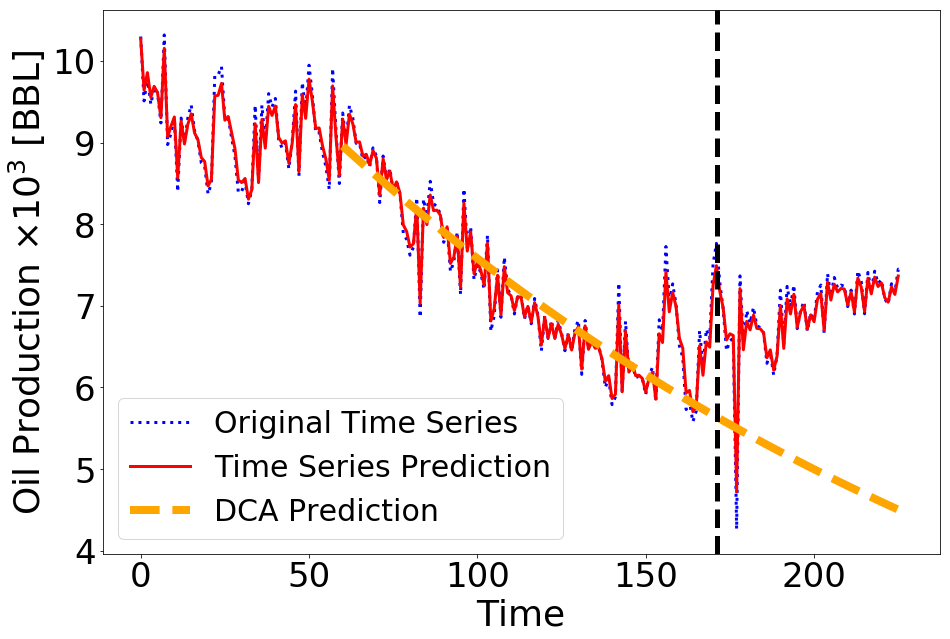

In [12]:
# print('Train RMSE: %.4f' % train_rmse)
# print('Test RMSE: %.4f' % test_rmse)

series = read_csv('TimeSeries.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
raw_values = series.values
    
plt.rcParams["axes.titlesize"] = 50
plt.rcParams["legend.fontsize"] = 30
plt.rcParams["axes.labelsize"] = 36

'''
plot the actual data v.s. predicted data
'''
x = np.asanyarray(range(len(pred[3])))
y = 11.5*np.exp(-x/240)
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(raw_values, label='Original Time Series', color='blue',linewidth=3.0,linestyle=':')
ax.plot(pred[3], label='Time Series Prediction', color='red',linewidth=3.0)
ax.plot(x[60:],y[60:],  label='DCA Prediction', color='orange',linewidth=8, linestyle='--')
# ax.plot(DCA_Prediction, label='DCA Prediction', color='black')
ax.axvline(x=len(raw_values)*0.75+1,color='k', linewidth=5, linestyle='--')
ax.legend(loc='lower left')
ax.set_xlabel('Time')
ax.xaxis.set_tick_params(labelsize=34)
ax.yaxis.set_tick_params(labelsize=34)

# plt.ylabel('oil production '+ r'$(10^4 m^3)$',fontsize = 16)
ax.set_ylabel(r'Oil Production $\times 10^3$ [BBL]')
fig.savefig('./Code3_Results/LSTMResult.pdf')